In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [5]:
df = pd.read_csv('patient-doctor.csv')
df['Doctor'] = df['Doctor'].apply(lambda text: '<start> ' + text + ' <end>')
df

,Patient,Doctor
0,hello good morning doctor,<start> good morning how are you feeling today...
1,ive been feeling quite anxious lately its been...,<start> i see can you tell me more about what ...
2,i think its mainly related to my job and the p...,<start> stress at work can definitely take a t...
3,i work in a highly demanding environment and i...,<start> that sounds tough do you have any supp...
4,i try to talk to my friends but they dont alwa...,<start> having a strong support system is impo...
...,...,...
1503,i find it difficult to cope and the grief ofte...,<start> coping with grief can be emotionally e...
1504,i havent been very open about my struggles as ...,<start> its common to feel hesitant about shar...
1505,lately i havent been actively practicing selfc...,<start> practicing selfcompassion and engaging...
1506,i havent sought professional help yet im unsur...,<start> seeking professional help such as ther...


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(input_texts, target_texts):
    # Create a tokenizer and fit on the input and target texts
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(input_texts + target_texts)

    # Convert input and target texts to sequences of integers
    encoder_input_sequences = tokenizer.texts_to_sequences(input_texts)
    decoder_input_sequences = tokenizer.texts_to_sequences(target_texts)

    # Calculate max sequence length
    max_sequence_length = max(max(len(seq) for seq in encoder_input_sequences),
                             max(len(seq) for seq in decoder_input_sequences))

    # Pad sequences to have the same length
    encoder_input_data = pad_sequences(encoder_input_sequences, maxlen=max_sequence_length, padding='post')
    decoder_input_data = pad_sequences(decoder_input_sequences, maxlen=max_sequence_length, padding='post')

    # Shift target sequences by one time step and convert to one-hot encoding
    decoder_target_data = np.zeros_like(decoder_input_data)
    decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
    decoder_target_data[:, -1] = tokenizer.word_index['<end>']

    # Return preprocessed data and tokenizer
    return encoder_input_data, decoder_input_data, decoder_target_data, tokenizer, max_sequence_length

In [6]:
input_texts = df['Patient'].astype(str).tolist()
target_texts = df['Doctor'].astype(str).tolist()
# Preprocess the data
encoder_input_data, decoder_input_data, decoder_target_data, tokenizer, max_sequence_length = preprocess_data(
    input_texts, target_texts)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate, Dot, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model(vocab_size, embedding_dim, hidden_dim, max_sequence_length):

    # Encoder
    encoder_inputs = Input(shape=(max_sequence_length,))
    encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(hidden_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_state_h = Concatenate()([forward_h, backward_h])
    encoder_state_c = Concatenate()([forward_c, backward_c])

    # Decoder
    decoder_inputs = Input(shape=(max_sequence_length,))
    decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(hidden_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[encoder_state_h, encoder_state_c])
    decoder_outputs = Dropout(0.2)(decoder_outputs)  # Adding Dropout layer for regularization


    # Attention mechanism
    attention = Dot(axes=[2, 2])
    attention_scores = attention([decoder_outputs, encoder_outputs])
    attention_weights = Activation('softmax')(attention_scores)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

    # Concatenate the context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer for generating the final output
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def train_model(model, encoder_input_data, decoder_input_data, decoder_target_data, batch_size, epochs, validation_split):
     # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # train the model
    model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=validation_split,
              callbacks=[early_stopping])

In [8]:
# Create the model
vocab_size = len(tokenizer.word_index) + 1
print('Vocab size: ', vocab_size)

# Hyperparameters
embedding_dim = 256
hidden_units = 256
batch_size = 32
epochs = 100
validation_split = 0.2

model = create_model(vocab_size, embedding_dim, hidden_units, max_sequence_length)

# Train the model
train_model(model, encoder_input_data, decoder_input_data, decoder_target_data, batch_size, epochs, validation_split)

Vocab size:  2737
Epoch 1/100
38/38 [==============================] - 159s 4s/step - loss: 6.2869 - accuracy: 0.0440 - val_loss: 5.5949 - val_accuracy: 0.0511
Epoch 2/100
38/38 [==============================] - 144s 4s/step - loss: 5.6452 - accuracy: 0.0657 - val_loss: 5.2488 - val_accuracy: 0.0985
Epoch 3/100
38/38 [==============================] - 145s 4s/step - loss: 5.2228 - accuracy: 0.1122 - val_loss: 4.6089 - val_accuracy: 0.1749
Epoch 4/100
38/38 [==============================] - 143s 4s/step - loss: 4.7167 - accuracy: 0.1911 - val_loss: 3.9339 - val_accuracy: 0.2784
Epoch 5/100
38/38 [==============================] - 140s 4s/step - loss: 4.2061 - accuracy: 0.2619 - val_loss: 3.3364 - val_accuracy: 0.3848
Epoch 6/100
38/38 [==============================] - 142s 4s/step - loss: 3.7675 - accuracy: 0.3202 - val_loss: 2.9018 - val_accuracy: 0.4489
Epoch 7/100
38/38 [==============================] - 145s 4s/step - loss: 3.4171 - accuracy: 0.3610 - val_loss: 2.5778 - val_accur

In [10]:
import pickle

# Save the trained model
model.save("models/PD_Bidirectional_model.h5")

# Save the tokenizer
with open("models/PD_Bidirectional_tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 110)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 110, 256)     700672      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 110)]        0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 110, 512),   1050624     ['embedding[0][0]']              
                                 (None, 256),                                                 

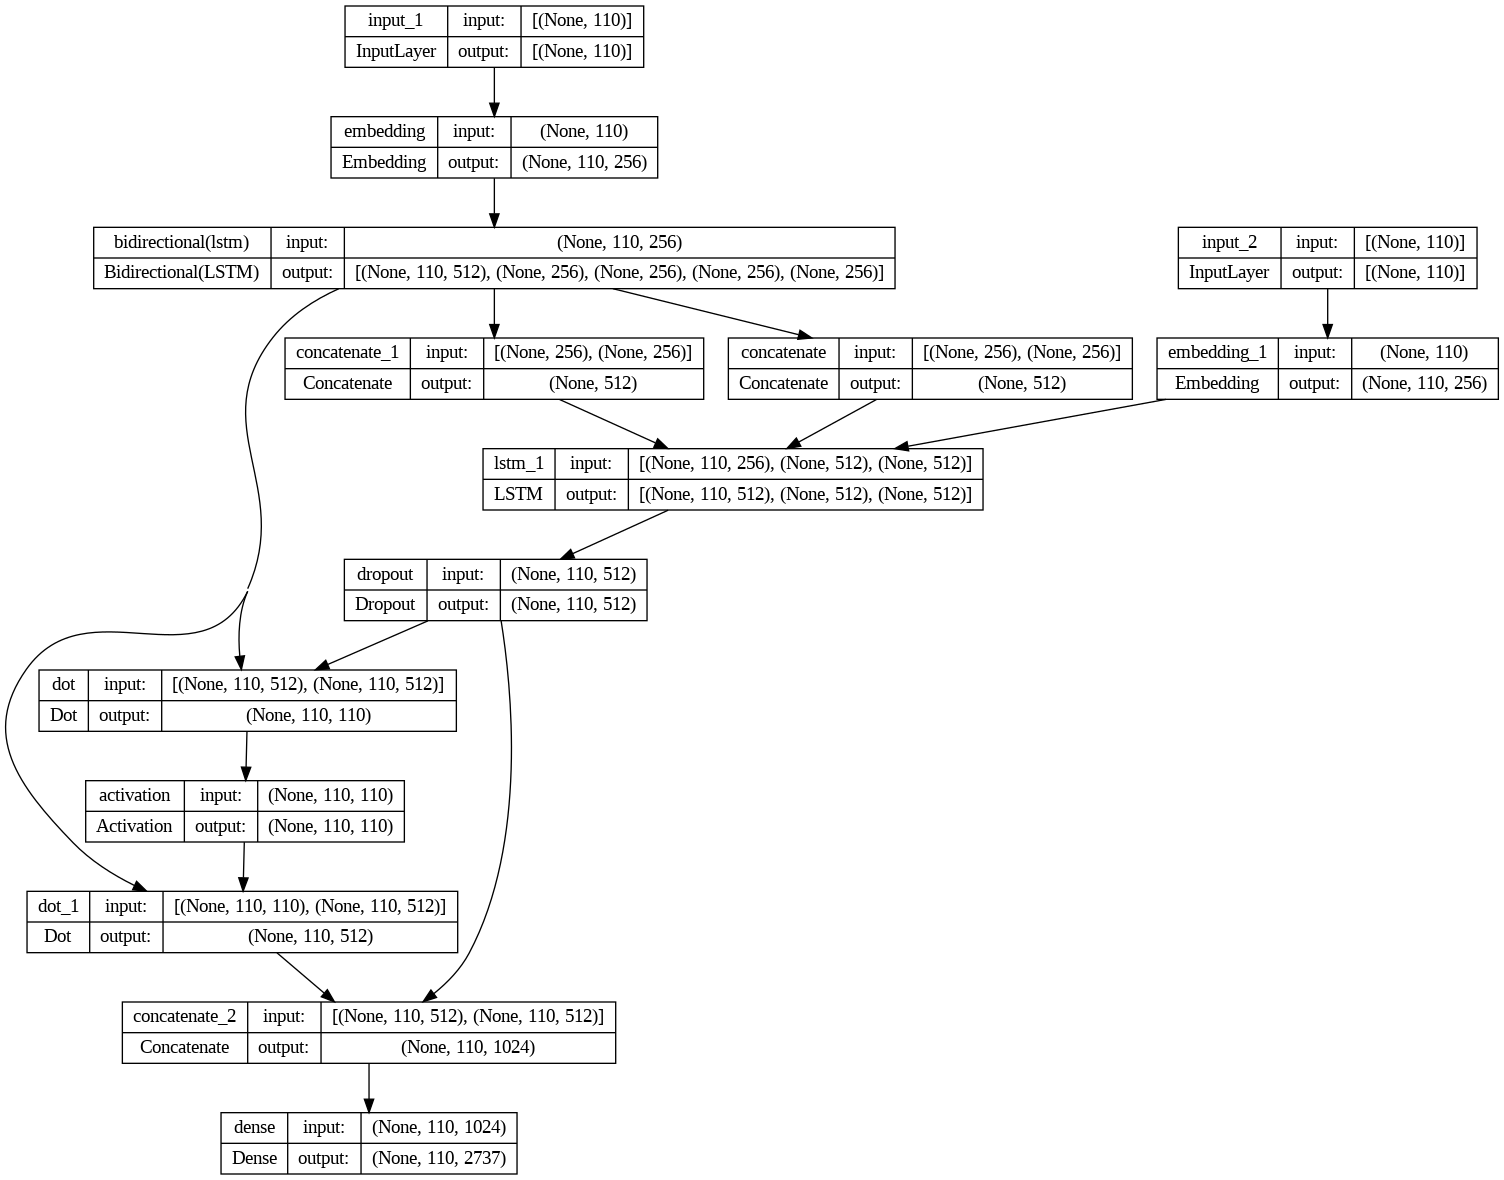

In [24]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import vis_utils

# Visualize the model architecture
vis_utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
